In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

import glob
import os
import boto3
import tempfile
from sqlalchemy import create_engine, MetaData, Table, select, and_, func
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.stats import norm
import tqdm
import pickle
from itertools import combinations
from aquabyte.optics import convert_to_world_point, depth_from_disp, pixel2world, euclidean_distance

from PIL import Image, ImageDraw
from multiprocessing import Pool, Manager
import copy
import uuid
from sklearn.preprocessing import StandardScaler
import random

pd.set_option('display.max_rows', 500)



In [2]:
aws_credentials = json.load(open(os.environ["AWS_CREDENTIALS"]))
s3_client = boto3.client('s3', aws_access_key_id=aws_credentials["aws_access_key_id"],
                         aws_secret_access_key=aws_credentials["aws_secret_access_key"],
                         region_name="eu-west-1")


sql_credentials = json.load(open(os.environ["SQL_CREDENTIALS"]))
sql_engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(sql_credentials["user"], sql_credentials["password"],
                           sql_credentials["host"], sql_credentials["port"],
                           sql_credentials["database"]))

Session = sessionmaker(bind=sql_engine)
session = Session()

Base = automap_base()
Base.prepare(sql_engine, reflect=True)
Enclosure = Base.classes.enclosures
Calibration = Base.classes.calibrations
GtsfDataCollection = Base.classes.gtsf_data_collections
StereoFramePair = Base.classes.stereo_frame_pairs


/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
def coord2biomass_linear(world_keypoints, model):
    """from coordinates to biomass"""

    mean = model['mean']
    std= model['std']
    PCA_components = model['PCA_components']
    reg_coef = model['reg_coef']
    reg_intercept = model['reg_intercept']
    body_parts = model['body_parts']

    # calculate pairwise distances for production coord
    # based on the exact ordering reflected in the body_parts
    # variable above

    pairwise_distances = []
    for i in range(len(body_parts)-1):
        for j in range(i+1, len(body_parts)):
            dist = euclidean_distance(world_keypoints[body_parts[i]], world_keypoints[body_parts[j]])
            pairwise_distances.append(dist)
    
    interaction_values = []
    for i in range(len(pairwise_distances)):
        for j in range(i, len(pairwise_distances)):
            dist1 = pairwise_distances[i]
            dist2 = pairwise_distances[j]
            interaction_values.append(dist1 * dist2)

    X = np.array(pairwise_distances + interaction_values)

    X_normalized = (X - model['mean']) / model['std']
    X_transformed = np.dot(X_normalized, model['PCA_components'].T)
    prediction = np.dot(X_transformed, reg_coef) + reg_intercept
    return prediction

def coord2biomass_blender(world_keypoints, blender):
    """from coordinates to biomass"""

    # mapping helps for consistency with the kp order
    reverse_mapping = blender["reverse_mapping"]
    distances = np.array(blender["distances"])
    volumes = blender["volume"]
    regression_coeff = blender["coeff"]

    # calculate pairwise distances for production coord
    # the reverse mapping insure that we listing the kp
    # in the same order
    measurements = []
    number_of_parts = len(world_keypoints)
    for k in range(number_of_parts):
        v = world_keypoints[reverse_mapping[str(k)]]
        for k0 in range(k+1, number_of_parts):
            v0 = world_keypoints[reverse_mapping[str(k0)]]
            dist = euclidean_distance(v, v0)*1000 # mm to m
            measurements.append(dist)
    measurements = np.array(measurements)

    # absolute diff
    diff = np.nanmean(np.abs(distances - measurements), axis=1)
    closest = np.argmin(diff)
    prediction = volumes[closest]

    # here is some machine learning
    prediction = prediction*regression_coeff[0] + regression_coeff[1]
    return prediction

In [4]:
model = pickle.load(open('./model.pkl', 'rb'))
blender = json.load(open('./volumes.json'))

In [5]:
session.rollback()
sfps_all = session.query(StereoFramePair).all()
df = pd.DataFrame()

for idx, row in enumerate(sfps_all):
    ground_truth_metadata = json.loads(row.ground_truth_metadata)
    
    # skip bad cases
    if row.gtsf_fish_identifier == '190321010002':
        print('Skipping fish ID {}'.format(row.gtsf_fish_identifier))
        continue
    if ground_truth_metadata['data'].get('species') != 'salmon':
        print('Skipping non-samlon fish: {}'.format(row.gtsf_fish_identifier))
        continue
        
    
    # get pairwise distances and biomass predictions
    world_keypoint_coordinates = json.loads(row.world_keypoint_coordinates)
    predicted_weight_linear = coord2biomass_linear(world_keypoint_coordinates, model)
    predicted_weight_blender = coord2biomass_blender(world_keypoint_coordinates, blender)
    predicted_length = euclidean_distance(world_keypoint_coordinates['UPPER_LIP'], world_keypoint_coordinates['TAIL_NOTCH'])
    
    df_row = {}
    body_parts = sorted(list(world_keypoint_coordinates.keys()))
    for i in range(len(body_parts)-1):
        for j in range(i+1, len(body_parts)):
            bp1, bp2 = body_parts[i], body_parts[j]
            df_row['{}<->{}'.format(body_parts[i], body_parts[j])] = \
                euclidean_distance(world_keypoint_coordinates[bp1], world_keypoint_coordinates[bp2])
            
    left_image_keypoint_coordinates = json.loads(row.left_image_keypoint_coordinates)
    right_image_keypoint_coordinates = json.loads(row.right_image_keypoint_coordinates)
    if row.annotations_project_name == 'Automated keypoints detection':
        left_image_keypoint_coordinates = {bp: (x[1], x[0]) for bp, x in left_image_keypoint_coordinates.items()}
        right_image_keypoint_coordinates = {bp: (x[1], x[0]) for bp, x in right_image_keypoint_coordinates.items()}
    
    keypoints_valid = True
    
    left_keypoint_y_coords = {bp: left_image_keypoint_coordinates[bp][1] for bp in left_image_keypoint_coordinates}
    right_keypoint_y_coords = {bp: right_image_keypoint_coordinates[bp][1] for bp in right_image_keypoint_coordinates}
    max_y_coordinate_deviation = \
        max([abs(left_keypoint_y_coords[bp] - right_keypoint_y_coords[bp]) for bp in body_parts])
            
    # append to dataset
    df_row.update({
        'gtsf_fish_identifier': row.gtsf_fish_identifier,
        'weight': ground_truth_metadata['data']['weight'],
        'length': ground_truth_metadata['data']['length'],
        'width': ground_truth_metadata['data']['width'],
        'breadth': ground_truth_metadata['data']['breath'],
        'world_keypoint_coordinates': world_keypoint_coordinates,
        'left_image_keypoint_coordinates': json.loads(row.left_image_keypoint_coordinates),
        'right_image_keypoint_coordinates': json.loads(row.right_image_keypoint_coordinates),
        'kfactor': 1e5 * ground_truth_metadata['data']['weight'] / ground_truth_metadata['data']['length']**3,
        'date': row.date,
        'left_image_s3_key': row.left_image_s3_key,
        'right_image_s3_key': row.right_image_s3_key,
        'image_s3_bucket': row.image_s3_bucket,
        'predicted_weight_linear': predicted_weight_linear,
        'predicted_weight_blender': predicted_weight_blender,
        'predicted_length': predicted_length,
        'error_pct_linear': (predicted_weight_linear - ground_truth_metadata['data']['weight']) / ground_truth_metadata['data']['weight'],
        'error_pct_blender': (predicted_weight_blender - ground_truth_metadata['data']['weight']) / ground_truth_metadata['data']['weight'],
        'project_name': row.annotations_project_name
    })
    
    df = df.append(df_row, ignore_index=True)
            
    
df_cache = df.copy()
df = df.dropna()
df = df[df.project_name != 'Automated keypoints detection']


Skipping non-samlon fish: 190226010007
Skipping non-samlon fish: 190226010005
Skipping non-samlon fish: 190226010001
Skipping non-samlon fish: 190227010001
Skipping non-samlon fish: 190227010003
Skipping non-samlon fish: 190227010010
Skipping non-samlon fish: 190227010012
Skipping non-samlon fish: 190227010008
Skipping non-samlon fish: 190227010006
Skipping non-samlon fish: 190227010014
Skipping non-samlon fish: 190227010016
Skipping non-samlon fish: 190319010033
Skipping non-samlon fish: 190319010034
Skipping non-samlon fish: 190319010036
Skipping non-samlon fish: 190319010035
Skipping fish ID 190321010002
Skipping non-samlon fish: 190328010035
Skipping non-samlon fish: 190328010034


<h1> Construct new df with jitters introduced </h1>

In [56]:
gtsf_data_collection = session.query(GtsfDataCollection).first()

In [6]:
gtsf_data_collection = session.query(GtsfDataCollection).first()
calibration = session.query(Calibration) \
             .filter(Calibration.enclosure_id == gtsf_data_collection.enclosure_id) \
             .order_by(Calibration.utc_timestamp.desc()) \
             .first()

enclosure = session.query(Enclosure).get(calibration.enclosure_id)


focal_length = float(calibration.predicted_focal_length_mm) / (1e3)
baseline = float(calibration.predicted_baseline_mm) / (1e3)
pixel_size_m = float(enclosure.pixel_width_um) / (1e6)
focal_length_pixel = focal_length / pixel_size_m
image_sensor_width = float(enclosure.sensor_width_mm) / (1e3)
image_sensor_height = float(enclosure.sensor_height_mm) / (1e3)
pixel_count_width = enclosure.image_num_pixels_width
pixel_count_height = enclosure.image_num_pixels_height

parameters = {
    'baseline': baseline,
    'focalLengthPixel': focal_length_pixel,
    'imageSensorWidth': image_sensor_width,
    'imageSensorHeight': image_sensor_height,
    'pixelCountWidth': pixel_count_width,
    'pixelCountHeight': pixel_count_height,
    'pixelSize': pixel_size_m
}

parameters['focalLength'] = parameters['focalLengthPixel'] * parameters['pixelSize']

In [7]:
analysis_df = pd.DataFrame()
jitter_values_x = [10, 50]
trials = 10
for idx, row in df.iterrows():
    if idx % 10 == 0:
        print(idx)
    left_keypoints_original = row.left_image_keypoint_coordinates
    right_keypoints_original = row.right_image_keypoint_coordinates
    
    # introduce small jitter
    body_parts = sorted(left_keypoints_original.keys())
    for jitter_value_x in jitter_values_x:
        for t in range(trials):
            jitter_value_y = 0
            left_keypoints = {bp: [left_keypoints_original[bp][0] + random.gauss(0, jitter_value_x),
                                   left_keypoints_original[bp][1] + random.gauss(0, jitter_value_y)] for bp in body_parts}
            right_keypoints = {bp: [right_keypoints_original[bp][0] + random.gauss(0, jitter_value_x),
                                    right_keypoints_original[bp][1] + random.gauss(0, jitter_value_y)] for bp in body_parts}

            world_keypoints = {}
            
            for bp in body_parts:
                lkp, rkp = left_keypoints[bp], right_keypoints[bp]
                d = abs(lkp[0] - rkp[0])

                # compute world key point
                depth = depth_from_disp(d, parameters)
                wkp = convert_to_world_point(lkp[0], lkp[1], depth, parameters)

                world_keypoints[bp] = wkp

            predicted_weight_linear = coord2biomass_linear(world_keypoints, model)
            predicted_weight_blender = coord2biomass_blender(world_keypoints, blender)

            df_row = {
                'gtsf_fish_identifier': row.gtsf_fish_identifier,
                'predicted_weight_linear': predicted_weight_linear,
                'predicted_weight_blender': predicted_weight_blender,
                'weight': row.weight,
                'trial': t,
                'jitter_value_x': jitter_value_x
            }
            
            analysis_df = analysis_df.append(df_row, ignore_index=True)





0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680


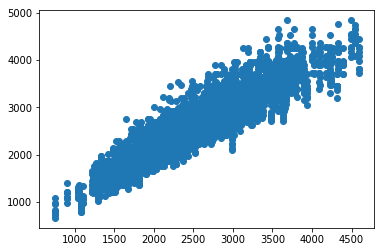

In [11]:


plt.show()

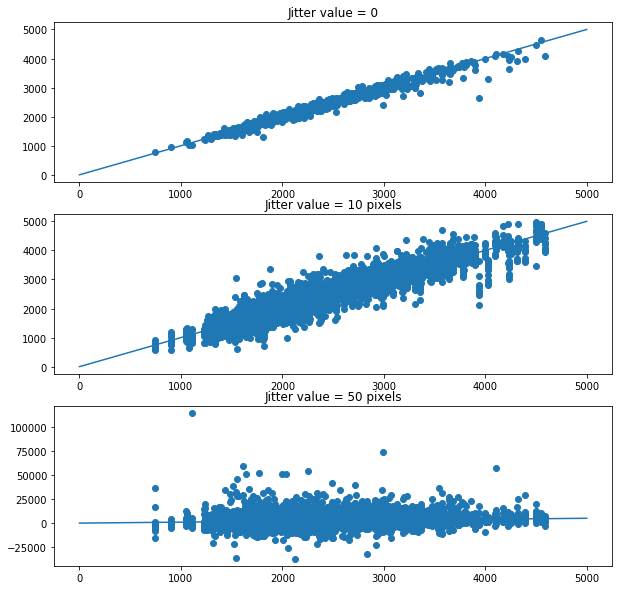

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].scatter(df.weight, df.predicted_weight_linear)
axes[0].plot([0, 5000], [0, 5000])
axes[0].set_title('Jitter value = 0')
mask = analysis_df.jitter_value_x == 10
axes[1].scatter(analysis_df[mask].weight, analysis_df[mask].predicted_weight_linear)
axes[1].plot([0, 5000], [0, 5000])
axes[1].set_title('Jitter value = 10 pixels')
mask = analysis_df.jitter_value_x == 50
axes[2].scatter(analysis_df[mask].weight, analysis_df[mask].predicted_weight_linear)
axes[2].plot([0, 5000], [0, 5000])
axes[2].set_title('Jitter value = 50 pixels')
plt.show()

In [107]:
((analysis_df[mask].predicted_weight_linear.mean()) - (analysis_df[mask].weight.mean())) / (analysis_df[mask].weight.mean())

-0.00655473150496994

In [98]:
(analysis_df.weight.mean())

2455.896501457726